In [1]:
# ----------------------------
# Notebook 2: Handling Epistemic Uncertainty (Including Calibration Analysis)
# ----------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import accuracy_score, brier_score_loss


In [2]:
# Cell 1: Introduction and Setup
iris = datasets.load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
class_names = iris.target_names

# Split data into train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [3]:
# Cell 2: Removing a Class from Training (simulate epistemic uncertainty)
# Remove 'Setosa' (class 0) from training data
mask = y_train != 0
X_train_ep = X_train[mask]
y_train_ep = y_train[mask]

In [4]:
# Cell 3: Imputing Missing Features
# Randomly remove 20% of feature values in training and test sets
def introduce_missing(X, missing_rate=0.2, random_state=42):
    np.random.seed(random_state)
    X_missing = X.copy()
    n_samples, n_features = X_missing.shape
    mask = np.random.rand(n_samples, n_features) < missing_rate
    X_missing[mask] = np.nan
    return X_missing
X_train_miss = introduce_missing(X_train_ep, 0.2)
X_test_miss  = introduce_missing(X_test, 0.2)

# Impute missing values using Mean and KNN
mean_imputer = SimpleImputer(strategy='mean')
knn_imputer  = KNNImputer(n_neighbors=5)

X_train_mean = mean_imputer.fit_transform(X_train_miss)
X_test_mean  = mean_imputer.transform(X_test_miss)

X_train_knn  = knn_imputer.fit_transform(X_train_miss)
X_test_knn   = knn_imputer.transform(X_test_miss)

# For demonstration, we use KNN imputed data for model training
X_train_used = X_train_knn.copy()
X_test_used  = X_test_knn.copy()

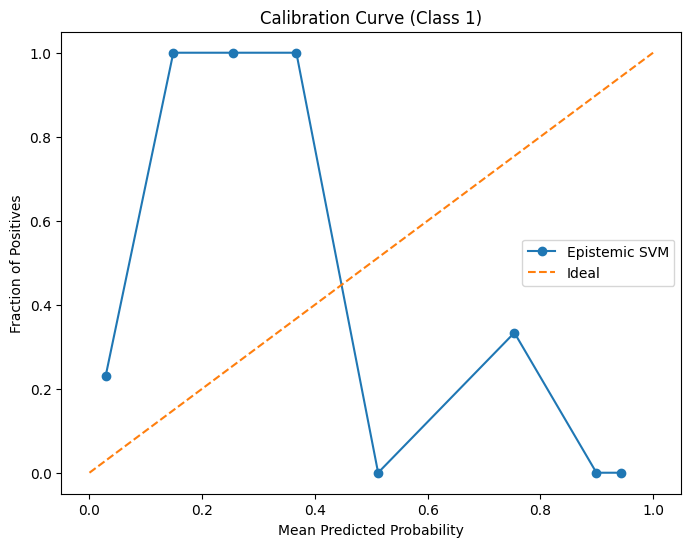

In [5]:
# Cell 4: Train SVM and Plot Calibration Curves (over-confident model)
svm_ep = SVC(probability=True, random_state=42)
svm_ep.fit(X_train_used, y_train_ep)
y_proba = svm_ep.predict_proba(X_test_used)

# Calibration curve for class 1 (binary one-vs-rest)
prob_true, prob_pred = calibration_curve((y_test==1).astype(int), y_proba[:,1], n_bins=10)
plt.figure(figsize=(8,6))
plt.plot(prob_pred, prob_true, marker='o', label='Epistemic SVM')
plt.plot([0,1],[0,1],'--', label='Ideal')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve (Class 1)')
plt.legend()
plt.show()


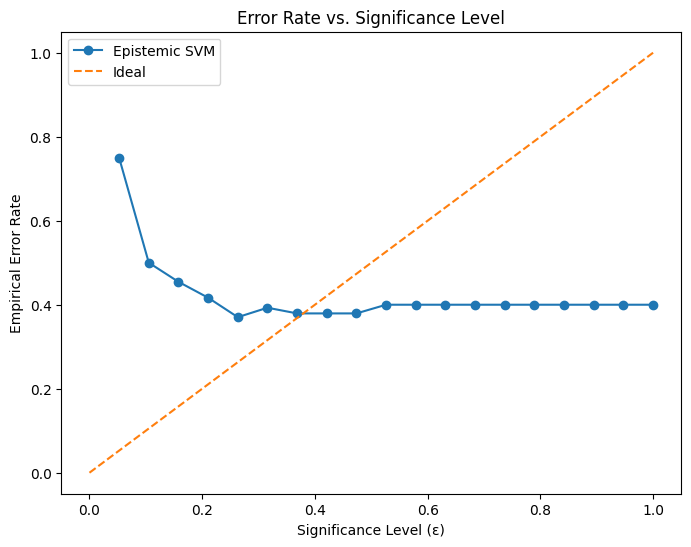

In [6]:
# Cell 5: Error Rate vs. Significance Level
def error_rate_vs_significance(model, X, y, epsilons):
    proba = model.predict_proba(X)
    confidences = np.max(proba, axis=1)
    uncertainties = 1 - confidences
    errors = []
    for eps in epsilons:
        idx = uncertainties <= eps
        if np.sum(idx) > 0:
            err = np.mean(model.predict(X)[idx] != y[idx])
        else:
            err = np.nan
        errors.append(err)
    return errors

epsilons = np.linspace(0,1,20)
errors_ep = error_rate_vs_significance(svm_ep, X_test_used, y_test, epsilons)
plt.figure(figsize=(8,6))
plt.plot(epsilons, errors_ep, marker='o', label='Epistemic SVM')
plt.plot(epsilons, epsilons, '--', label='Ideal')
plt.xlabel('Significance Level (ε)')
plt.ylabel('Empirical Error Rate')
plt.title('Error Rate vs. Significance Level')
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


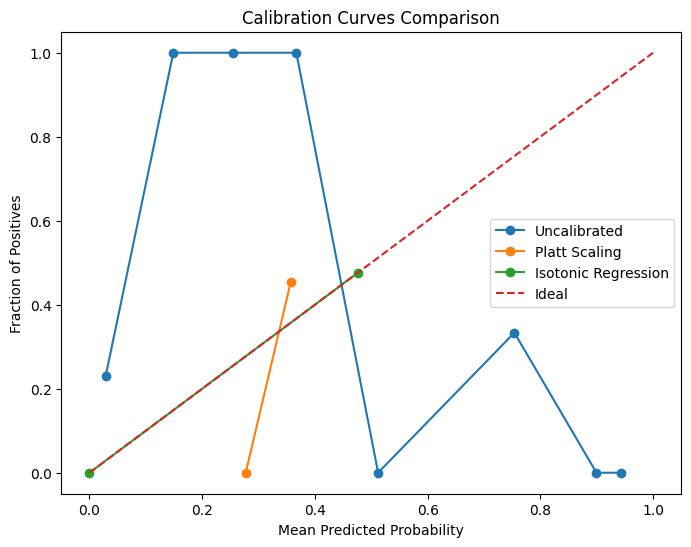

In [7]:
# Cell 6: Fixing Calibration with Platt Scaling & Isotonic Regression
platt_ep = CalibratedClassifierCV(svm_ep, cv='prefit', method='sigmoid')
platt_ep.fit(X_test_used, y_test)
isotonic_ep = CalibratedClassifierCV(svm_ep, cv='prefit', method='isotonic')
isotonic_ep.fit(X_test_used, y_test)

# Plot calibration curves for uncalibrated, Platt, and Isotonic models
plt.figure(figsize=(8,6))
for model, label in zip([svm_ep, platt_ep, isotonic_ep],
                        ['Uncalibrated', 'Platt Scaling', 'Isotonic Regression']):
    p_true, p_pred = calibration_curve((y_test==1).astype(int), model.predict_proba(X_test_used)[:,1], n_bins=10)
    plt.plot(p_pred, p_true, marker='o', label=label)
plt.plot([0,1],[0,1],'--', label='Ideal')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curves Comparison')
plt.legend()
plt.show()

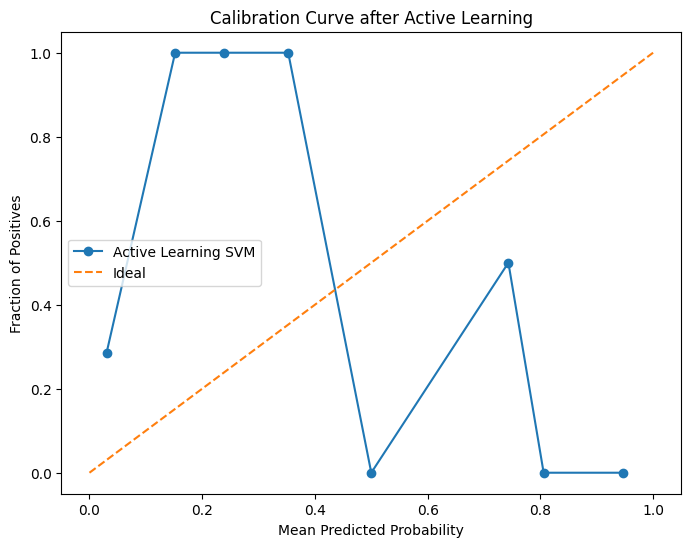

In [8]:
# Cell 7: Active Learning - Adding High Uncertainty Samples to Training
# Identify samples with highest uncertainty from test set
proba_test = svm_ep.predict_proba(X_test_used)
uncertainty = 1 - np.max(proba_test, axis=1)
n_active = int(0.1 * len(X_test_used))  # add top 10% uncertain samples
active_idx = np.argsort(-uncertainty)[:n_active]
# Add these samples (with true labels) to training set
X_train_active = np.vstack([X_train_used, X_test_used[active_idx]])
y_train_active = np.concatenate([y_train_ep, y_test[active_idx]])

# Retrain model with active learning samples
svm_active = SVC(probability=True, random_state=42)
svm_active.fit(X_train_active, y_train_active)
y_proba_active = svm_active.predict_proba(X_test_used)

# Plot calibration curve for active learning model (class 1)
p_true_active, p_pred_active = calibration_curve((y_test==1).astype(int), y_proba_active[:,1], n_bins=10)
plt.figure(figsize=(8,6))
plt.plot(p_pred_active, p_true_active, marker='o', label='Active Learning SVM')
plt.plot([0,1],[0,1],'--', label='Ideal')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve after Active Learning')
plt.legend()
plt.show()

In [9]:
# Cell 8: Final Comparison Metrics
def evaluate_model(model, X, y):
    pred = model.predict(X)
    acc = accuracy_score(y, pred)
    brier = brier_score_loss((y==1).astype(int), model.predict_proba(X)[:,1])
    return acc, brier

acc_uncal, brier_uncal = evaluate_model(svm_ep, X_test_used, y_test)
acc_platt, brier_platt = evaluate_model(platt_ep, X_test_used, y_test)
acc_active, brier_active = evaluate_model(svm_active, X_test_used, y_test)

print("Uncalibrated SVM: Accuracy={:.2f}, Brier Score={:.4f}".format(acc_uncal, brier_uncal))
print("Platt Scaled SVM: Accuracy={:.2f}, Brier Score={:.4f}".format(acc_platt, brier_platt))
print("Active Learning SVM: Accuracy={:.2f}, Brier Score={:.4f}".format(acc_active, brier_active))

Uncalibrated SVM: Accuracy=0.60, Brier Score=0.4694
Platt Scaled SVM: Accuracy=0.33, Brier Score=0.2205
Active Learning SVM: Accuracy=0.60, Brier Score=0.4808
